# Scheduling benchmarks analysis

## Library

In [1]:
import matplotlib.pyplot as plt
from typing import Optional, List, Tuple
import pandas as pd
import os
import re
import json
import subprocess
from enum import Enum
import lib
import numpy as np
import seaborn as sns
from collections import defaultdict

import importlib

# make changes to example.py file

importlib.reload(lib)

from lib import get_runs_dataframe

/tmp/ipykernel_824043/341193079.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### Global variables

In [2]:
TRACE_CMD_CACHE_FILENAME = "trace_cmd_runtimes"
RESULTS_DIR_PATH = "../results"

USE_TRACE_CMD_CACHE = True

def get_result_dir_path(result_dir_name):
    return os.path.join(RESULTS_DIR_PATH, result_dir_name)

#### Visualization params

In [3]:
DEFAULT_FIGURE_HEIGHT = 12

nb_enabled_color = "tab:orange"
nb_disabled_color = "tab:blue"

figure_height = DEFAULT_FIGURE_HEIGHT
min_figure_width = 40
figure_width_coeff = 0.3

line_width = 1.0

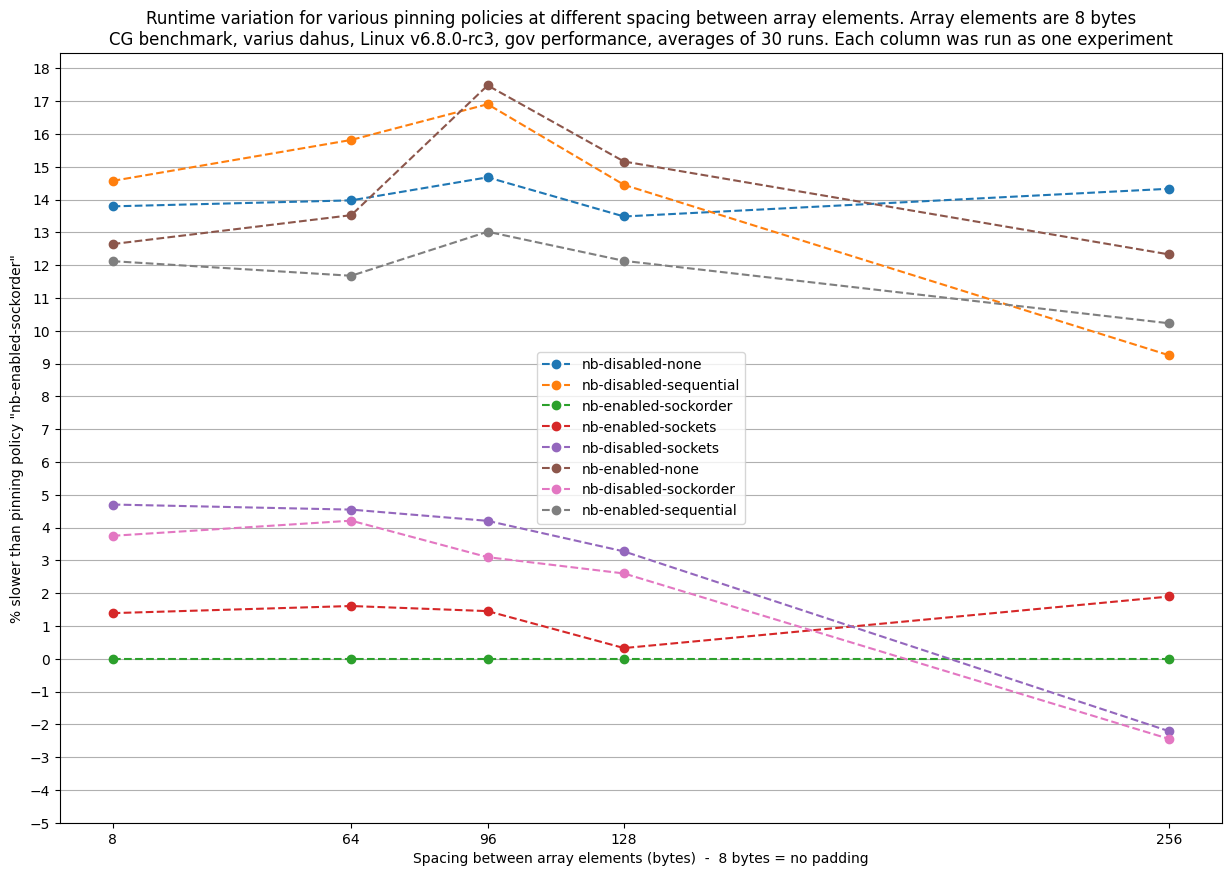

In [34]:
# Parsing hyperfine runs

# The core idea is that if we space ouf the data we don't see that phenomenon anymore
# So we want to have the scaling factor on the x axis, and how much slower each of them is compared to the reference value




def get_average_from_benchmark(benchmark_dir_name, space_multiplier, variations = True) :
    averages = {}
    benchmark_path = os.path.join(get_result_dir_path("_spacing"), benchmark_dir_name)
    for file_name in os.listdir(benchmark_path) :
        file_path = os.path.join(benchmark_path, file_name)
        with open(file_path) as f :
            data = json.load(f)
        result = data['results'][0]
        times = np.array(result['times'])
        averages[result['command']] = times.mean()
    # reference_value = min([v for v in averages.values()])
    if variations :
        reference_value = averages["nb-enabled-sockorder"]
        for key, val in averages.items() :
            averages[key] = (val - reference_value) * 100 / reference_value
    padding = space_multiplier * 8
    return (averages, padding)
        

# with open(get_result_dir_path("_spacing/cg.C.x__spaced_12_times__dahu-7__v6.8.0-rc3__performance__2024-04-24/nb-disabled-none.json")) as f :
#     data = json.load(f)
    
# # np.array(data['results'][0]['times']).mean()
# data

benchmark_dirs = [
    ("cg.C.x__dahu-7__v6.8.0-rc3__performance__2024-04-24__spaced_normal", 1),
    ("cg.C.x__dahu-28__v6.8.0-rc3__performance__2024-04-24__spaced_8_times", 8),
    ("cg.C.x__dahu-7__v6.8.0-rc3__performance__2024-04-24__spaced_12_times", 12),
    ("cg.C.x__dahu-8__v6.8.0-rc3__performance__2024-04-25__spaced_16_times", 16),
    ("cg.C.x__dahu-32__v6.8.0-rc3__performance__2024-04-25__spaced_32_times", 32)
]

# get_average_variation_from_benchmark("cg.C.x__spaced_12_times__dahu-7__v6.8.0-rc3__performance__2024-04-24")

average_data = defaultdict(list)
padding_values = []

for bd in benchmark_dirs :
    averages, padding = get_average_from_benchmark(*bd)
    for key, val in averages.items() :
        average_data[key].append(val)
    padding_values.append(padding)
    
for key in average_data :
    plt.plot(padding_values, average_data[key], label=key, marker='o', linestyle='--')
plt.ylabel("% slower than pinning policy \"nb-enabled-sockorder\"")
plt.xlabel("Spacing between array elements (bytes)  -  8 bytes = no padding")
plt.title("Runtime variation for various pinning policies at different spacing between array elements. Array elements are 8 bytes\nCG benchmark, varius dahus, Linux v6.8.0-rc3, gov performance, averages of 30 runs. Each column was run as one experiment")
plt.legend(loc="best")
plt.xticks([8, 64, 96, 128, 256])
plt.yticks([i for i in range(-5, 19)])
# plt.minorticks_on()
# plt.xticks()
plt.grid(axis="y", which="both")
# plt.grid(axis="x", which="major")
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()


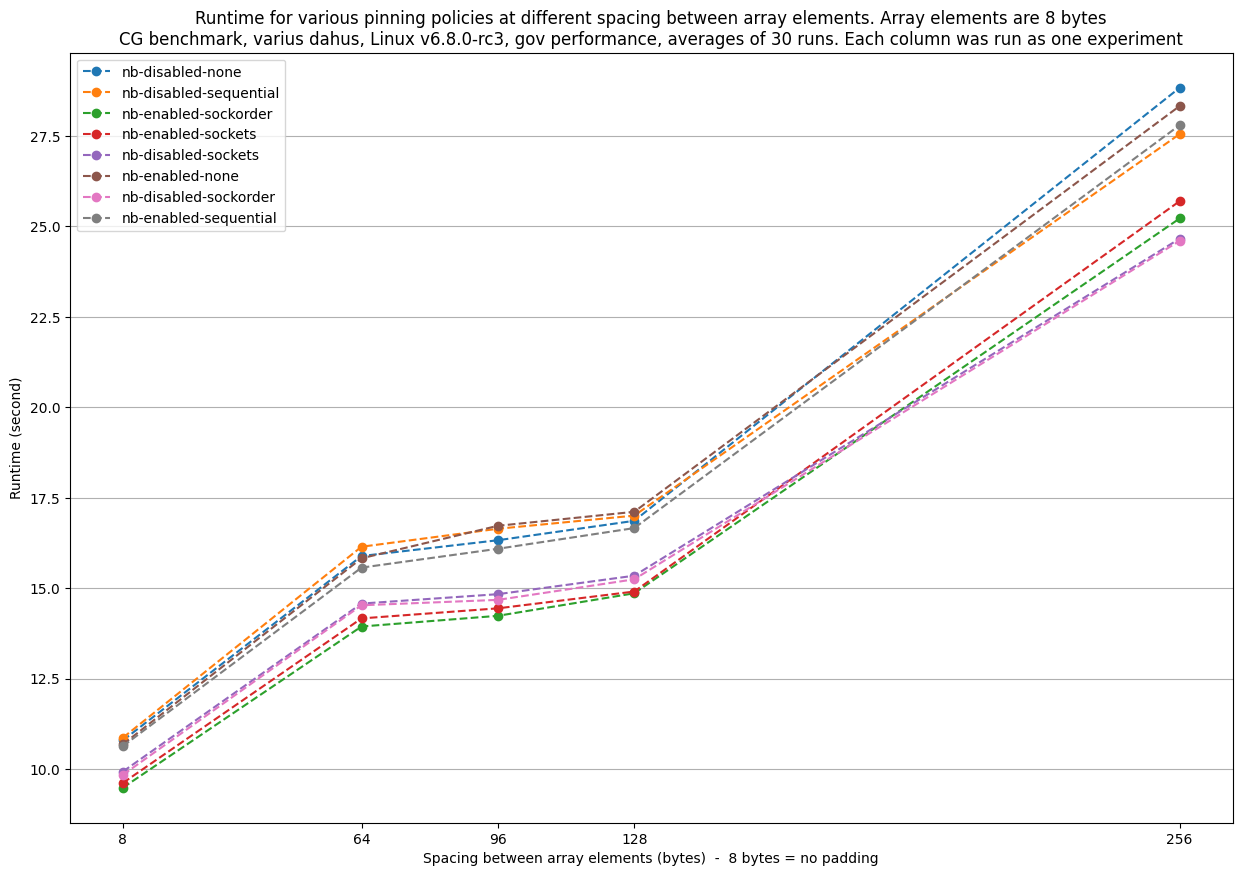

In [35]:

average_data = defaultdict(list)
padding_values = []

for bd in benchmark_dirs :
    averages, padding = get_average_from_benchmark(*bd, False)
    for key, val in averages.items() :
        average_data[key].append(val)
    padding_values.append(padding)
for key in average_data :
    plt.plot(padding_values, average_data[key], label=key, marker='o', linestyle='--')
plt.ylabel("Runtime (second)")
plt.xlabel("Spacing between array elements (bytes)  -  8 bytes = no padding")
plt.title("Runtime for various pinning policies at different spacing between array elements. Array elements are 8 bytes\nCG benchmark, varius dahus, Linux v6.8.0-rc3, gov performance, averages of 30 runs. Each column was run as one experiment")
plt.legend(loc="best")
plt.xticks([8, 64, 96, 128, 256])
# plt.yticks([i for i in range(-5, 19)])
# plt.minorticks_on()
# plt.xticks()
plt.grid(axis="y", which="both")
# plt.grid(axis="x", which="major")
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()
    